In [7]:
# Load packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import scipy as scp
import scipy.stats as scps
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pickle
import time

# Load my own functions
import dnnregressor_train_eval_keras as dnnk
import make_data_wfpt as mdw
from kde_training_utilities import kde_load_data
import ddm_data_simulation as ddm_sim
import boundary_functions as bf

In [2]:
# Enable cuda
#os.environ['CUDA_VISIBLE_DEVICES'] = '2'
scp.__version__

'1.1.0'

In [3]:
# Load Model
model_path = '/home/afengler/git_repos/nn_likelihoods/keras_models/dnnregressor_kde_ddm_weibull_06_05_19_14_07_16/model_0' 
ckpt_path = '/home/afengler/git_repos/nn_likelihoods/keras_models/dnnregressor_kde_ddm_weibull_06_05_19_14_07_16/ckpt_0_final'
model = keras.models.load_model(model_path)
model.load_weights(ckpt_path)

In [35]:
 # Initializations -----
n_runs = 300
n_samples = 2500
v_range = [-2.5, 2.5]
a_range = [0.1, 4] # previous [1,2] # previous [2, 3]
w_range = [0.15, 0.85]
node_range = [0, 1]
shape_range = [1.01, 5]
scale_range = [0.1, 5]

my_optim_columns = ['file', 'nde', 'n_samples', 'v_mle', 'a_mle', 'w_mle', 'node_mle', 'shape_mle', 'scale_mle']

# Get parameter names in correct ordering:
dat = pickle.load(open('/home/afengler/git_repos/nn_likelihoods/data_storage/kde/weibull/train_test_data/test_features.pickle' , 
                       'rb'))

parameter_names = list(dat.keys())[:-2] # :-1 to get rid of 'rt' and 'choice' here

# # Make columns for optimizer result table
# p_sim = []
# p_mle = []

# for parameter_name in parameter_names:
#     p_sim.append(parameter_name + '_sim')
#     p_mle.append(parameter_name + '_mle')
    
# my_optim_columns = p_sim + p_mle + ['n_samples']

# define boundary
boundary = bf.weibull_bnd
boundary_multiplicative = False

# Define the likelihood function
def log_p(params = [0, 1, 0.9], model = [], data = [], parameter_names = []):
    # Make feature array
    feature_array = np.zeros((data[0].shape[0], len(parameter_names) + 2))
    
    # Store parameters
    cnt = 0
    for i in range(0, len(parameter_names), 1):
        feature_array[:, i] = params[i]
        cnt += 1
    
    # Store rts and choices
    feature_array[:, cnt] = data[0].ravel() # rts
    feature_array[:, cnt + 1] = data[1].ravel() # choices
    
    # Get model predictions
    prediction = model.predict(feature_array)
    
    # Some post-processing of predictions
    prediction[prediction < 1e-29] = 1e-29
    
    return(- np.sum(np.log(prediction)))  
# ---------------------

In [36]:
# READING IN DATA -- (in case we use real data)
ddm_model = 'flexbound'
data_file = os.getcwd() + '/data_storage/michael_bg_nn_data/bg_stn_full.csv'
data = pd.read_csv(data_file)
files_ = np.unique(data['file'])

# Initialize the data frame in which to store optimizer results
optim_results = pd.DataFrame(np.zeros((len(files_), len(my_optim_columns))), columns = my_optim_columns)


In [37]:
# Main loop ----------- TD: Parallelize
cnt = 0
for file_ in files_: 
    
    # Print some info 
    print('Now running: ')
    print(file_)
    
    # Get start time
    start_time = time.time()
    
    # Handle data
    data_tmp = data.loc[data['file'] == file_,].copy()
    ndt = (min(data_tmp['avg_cycles'])) - 0.05 
    data_tmp['avg_cycles'] = data_tmp['avg_cycles'] - ndt
    data_feed_tmp = [data_tmp['avg_cycles'].values, data_tmp['cnt_err'].values]

    # Store file, ndt and n_samples in optim_results output
    optim_results.iloc[cnt, 0] = file_
    optim_results.iloc[cnt, 1] = ndt
    optim_results.iloc[cnt, 2] = data_tmp.shape[0]

    # Run differential evolution
    out = differential_evolution(log_p, 
                                 bounds = [(v_range[0],v_range[1]), 
                                           (a_range[0], a_range[1]), 
                                           (w_range[0], w_range[1]),
                                           (node_range[0], node_range[1]),
                                           (shape_range[0], shape_range[1]),
                                           (scale_range[0], scale_range[1])], 
                                 args = (model, data_feed_tmp, parameter_names), 
                                 popsize = 30,
                                 disp = True)
    
    # Print some info
    print('Solution vector of current run: ')
    print(out.x)
    
    # Store optimization results
    optim_results.iloc[cnt, 3:len(my_optim_columns)] = out.x
    
    # Print some info
    print('The run took: ')
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
    cnt += 1
# -----------------------

# Save optimization results to file
optim_results.to_csv(os.getcwd() + '/experiments/ddm_flexbound_kde_bg_stn_full_ndt_minrt/optim_results_c1_c2_extended_params.csv')

Now running: 
hiconf_go_stnhi.txt
differential_evolution step 1: f(x)= 1169.87
differential_evolution step 2: f(x)= 946.785
differential_evolution step 3: f(x)= 946.785
differential_evolution step 4: f(x)= 727.715
differential_evolution step 5: f(x)= 727.715
differential_evolution step 6: f(x)= 514.849
differential_evolution step 7: f(x)= 369.691
differential_evolution step 8: f(x)= 342.286
differential_evolution step 9: f(x)= 283.656
differential_evolution step 10: f(x)= 135.133
differential_evolution step 11: f(x)= 49.1225
differential_evolution step 12: f(x)= 49.1225
differential_evolution step 13: f(x)= 49.1225
differential_evolution step 14: f(x)= 49.1225
differential_evolution step 15: f(x)= -43.082
differential_evolution step 16: f(x)= -68.1684
differential_evolution step 17: f(x)= -68.1684
differential_evolution step 18: f(x)= -68.1684
differential_evolution step 19: f(x)= -125.378
differential_evolution step 20: f(x)= -125.378
differential_evolution step 21: f(x)= -152.625
dif

differential_evolution step 48: f(x)= -2192.59
differential_evolution step 49: f(x)= -2213.39
differential_evolution step 50: f(x)= -2213.39
differential_evolution step 51: f(x)= -2213.39
differential_evolution step 52: f(x)= -2213.39
differential_evolution step 53: f(x)= -2245.02
differential_evolution step 54: f(x)= -2245.02
differential_evolution step 55: f(x)= -2262.58
differential_evolution step 56: f(x)= -2262.58
differential_evolution step 57: f(x)= -2262.58
differential_evolution step 58: f(x)= -2262.58
differential_evolution step 59: f(x)= -2262.58
differential_evolution step 60: f(x)= -2262.58
differential_evolution step 61: f(x)= -2262.58
differential_evolution step 62: f(x)= -2278.68
differential_evolution step 63: f(x)= -2278.68
differential_evolution step 64: f(x)= -2278.68
differential_evolution step 65: f(x)= -2278.68
differential_evolution step 66: f(x)= -2278.68
differential_evolution step 67: f(x)= -2279.91
differential_evolution step 68: f(x)= -2281.9
differential_e

differential_evolution step 49: f(x)= -4079.32
differential_evolution step 50: f(x)= -4079.32
differential_evolution step 51: f(x)= -4079.32
differential_evolution step 52: f(x)= -4079.32
differential_evolution step 53: f(x)= -4089.7
differential_evolution step 54: f(x)= -4094.29
differential_evolution step 55: f(x)= -4094.29
differential_evolution step 56: f(x)= -4094.29
differential_evolution step 57: f(x)= -4094.29
differential_evolution step 58: f(x)= -4094.61
differential_evolution step 59: f(x)= -4094.61
differential_evolution step 60: f(x)= -4104.16
differential_evolution step 61: f(x)= -4104.16
differential_evolution step 62: f(x)= -4113.24
differential_evolution step 63: f(x)= -4113.6
differential_evolution step 64: f(x)= -4113.6
differential_evolution step 65: f(x)= -4113.6
differential_evolution step 66: f(x)= -4113.6
differential_evolution step 67: f(x)= -4113.6
differential_evolution step 68: f(x)= -4113.6
differential_evolution step 69: f(x)= -4113.6
Solution vector of cu

In [ ]:
# Save optimization results to file
optim_results.to_csv(os.getcwd() + '/experiments/kde_bg_stn_full_ndt_minrt_weibull/optim_results.csv')

In [19]:
optim_results

,file,nde,n_samples,v_mle,a_mle,w_mle,node_mle,shape_mle,scale_mle
0,hiconf_go_stnhi.txt,0.27,5000.0,1.867971,0.713922,0.432325,0.000025,1.110963,0.110503
1,hiconf_go_stnlo.txt,0.18,5000.0,1.883348,0.708990,0.429812,0.000835,1.111356,0.110932
2,hiconf_go_stnmid.txt,0.24,5000.0,1.118024,0.632072,0.404706,0.000679,1.110512,0.110675
3,loconf7_go_stnhi.txt,0.23,5000.0,2.055080,0.714608,0.430871,0.000193,1.111348,0.110777
4,loconf7_go_stnlo.txt,0.20,5000.0,2.055245,0.672189,0.408780,0.005428,1.132166,0.121072
5,loconf7_go_stnmid.txt,0.20,5000.0,2.057710,0.716730,0.439830,0.000374,1.112510,0.111423


In [27]:
# NEW DIAGNOSTIC GRAPHS HERE
ddm_dat_tmp = ddm_sim.ddm_flexbound_simulate(v = optim_results.iloc[2, 3],
                                             a = optim_results.iloc[2, 4],
                                             w = optim_results.iloc[2, 5],
                                             s = 1,
                                             delta_t = 0.001,
                                             max_t = 20,
                                             n_samples = 3000,
                                             boundary_fun = bf.weibull_bnd, # function of t (and potentially other parameters) that takes in (t, *args)
                                             boundary_multiplicative = False,
                                             boundary_params = {'node': optim_results.iloc[2, 6], 
                                                                'shape': optim_results.iloc[2, 7],
                                                                'scale': optim_results.iloc[2, 8]})

0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled


(0, 3)

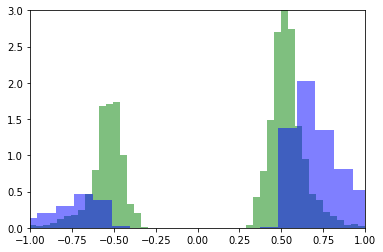

In [34]:
dat_tmp = data.loc[data['file'] == optim_results.iloc[2, 0], ]
plt.hist(dat_tmp['avg_cycles'] * dat_tmp['cnt_err'], bins = 50, color = 'green', density = True, alpha= 0.5)
plt.ylim((0, 3))
plt.xlim((-1, 1))

plt.hist((ddm_dat_tmp[0] + optim_results.iloc[2, 1]) * ddm_dat_tmp[1], bins = 50, color = 'blue', density = True, alpha = 0.5)
plt.ylim((0, 3))

In [ ]:
optim_results.iloc[3,3]

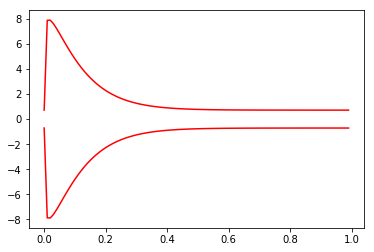

In [30]:
# Boundary plots
t_s = np.arange(0, 1, 0.01)
boundary = np.zeros((len(t_s),2))
colors = ['red', 'green', 'blue']
a = optim_results.iloc[0, 4]
color_cnt = 0

cnt = 0
for i in t_s:
    b = a + bf.weibull_bnd(t = i, 
                           node = optim_results.iloc[2, 6], 
                           shape = optim_results.iloc[2, 7],
                           scale = optim_results.iloc[2, 8])
    if b <= 0:
        boundary[cnt, 0] = 0
        boundary[cnt, 1] = 0
    else: 
        boundary[cnt, 0] = b
        boundary[cnt, 1] = - boundary[cnt, 0]
    cnt += 1

plt.plot(t_s, boundary[:, 0], color = colors[color_cnt])
plt.plot(t_s, boundary[:, 1], color = colors[color_cnt]) 
color_cnt += 1

In [ ]:
dat_tmp = data.loc[data['file'] == optim_results.iloc[0, 0], ]
plt.hist(dat_tmp['avg_cycles'] * dat_tmp['cnt_err'], bins = 30, color = 'blue', density=True)
plt.ylim((0, 5))

In [ ]:
optim_results